In [7]:
import numpy as np
from scipy.optimize import line_search

def objective_function(x):
    """Compute the objective function value."""
    x1, x2, x3 = x
    return x1**2 * x2 + 4 * x2**2 - x2 * x3 + 1/x3

def gradient(x):
    """Compute the gradient of the objective function."""
    x1, x2, x3 = x
    df_dx1 = 2 * x1 * x2
    df_dx2 = x1**2 + 8 * x2 - x3
    df_dx3 = -x2 - 1 / (x3**2)
    return np.array([df_dx1, df_dx2, df_dx3])

def hessian(x):
    """Compute the Hessian of the objective function."""
    x1, x2, x3 = x
    # Initialize 3x3 Hessian matrix
    H = np.zeros((3, 3))
    
    # First row
    H[0, 0] = 2 * x2
    H[0, 1] = 2 * x1
    H[0, 2] = 0
    
    # Second row
    H[1, 0] = 2 * x1
    H[1, 1] = 8
    H[1, 2] = -1
    
    # Third row
    H[2, 0] = 0
    H[2, 1] = -1
    H[2, 2] = 2 / (x3**3)
    
    return H

def armijo_condition(f, xk, pk, grad, alpha, c1=1e-4):
    """Check Armijo condition for sufficient decrease."""
    return f(xk + alpha * pk) <= f(xk) + c1 * alpha * np.dot(grad, pk)

def line_search_armijo(f, xk, pk, grad, alpha_init=1.0, rho=0.5, c1=1e-4, max_iter=100):
    """Backtracking line search with Armijo condition."""
    alpha = alpha_init
    for _ in range(max_iter):
        if armijo_condition(f, xk, pk, grad, alpha, c1):
            return alpha
        alpha *= rho
    return alpha

def steepest_descent(f, grad_f, x0, tol=1e-6, max_iter=1000):
    """Steepest descent method with Armijo line search."""
    x = x0.copy()
    history = {'x': [x.copy()], 'f': [f(x)], 'grad_norm': [np.linalg.norm(grad_f(x))]}
    
    for _ in range(max_iter):
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        
        # Search direction is -gradient
        pk = -g
        
        # Perform Armijo line search
        alpha = line_search_armijo(f, x, pk, g)
        
        # Update x
        x = x + alpha * pk
        
        # Store history
        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['grad_norm'].append(np.linalg.norm(grad_f(x)))
    
    return x, history

def newton_method(f, grad_f, hess_f, x0, tol=1e-6, max_iter=1000):
    """Newton's method with Armijo line search."""
    x = x0.copy()
    history = {'x': [x.copy()], 'f': [f(x)], 'grad_norm': [np.linalg.norm(grad_f(x))]}
    
    for _ in range(max_iter):
        g = grad_f(x)
        H = hess_f(x)
        
        if np.linalg.norm(g) < tol:
            break
        
        try:
            # Solve Newton system H*pk = -g
            pk = np.linalg.solve(H, -g)
        except np.linalg.LinAlgError:
            # If Hessian is singular, use steepest descent direction
            pk = -g
        
        # Perform Armijo line search
        alpha = line_search_armijo(f, x, pk, g)
        
        # Update x
        x = x + alpha * pk
        
        # Store history
        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['grad_norm'].append(np.linalg.norm(grad_f(x)))
    
    return x, history

# Example usage
if __name__ == "__main__":
    # Initial guess (must be feasible, x3 > 0)
    x0 = np.array([1.0, 1.0, 1.0])
    
    # Run steepest descent
    print("Steepest Descent Method:")
    x_sd, hist_sd = steepest_descent(objective_function, gradient, x0)
    print(f"Optimal solution: {x_sd}")
    print(f"Function value: {objective_function(x_sd)}")
    print(f"Gradient norm: {np.linalg.norm(gradient(x_sd))}")
    print(f"Number of iterations: {len(hist_sd['x'])-1}")
    
    # Run Newton's method
    print("\nNewton's Method:")
    x_nt, hist_nt = newton_method(objective_function, gradient, hessian, x0)
    print(f"Optimal solution: {x_nt}")
    print(f"Function value: {objective_function(x_nt)}")
    print(f"Gradient norm: {np.linalg.norm(gradient(x_nt))}")
    print(f"Number of iterations: {len(hist_nt['x'])-1}")

Steepest Descent Method:
Optimal solution: [7.28041182e-01 1.64513869e+02 1.33688013e+03]
Function value: -111588.87016160373
Gradient norm: 291.3015603248617
Number of iterations: 1000

Newton's Method:
Optimal solution: [ 2.14936951 -0.12402786  2.0892754 ]
Function value: 0.22631225801596527
Gradient norm: 1.631453577512151
Number of iterations: 1000


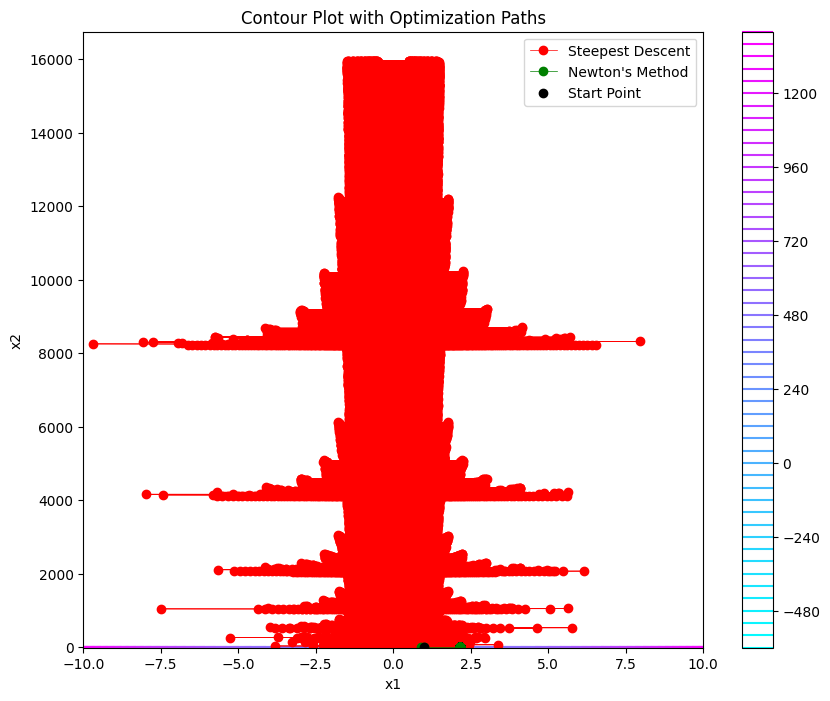

In [4]:
import matplotlib.pyplot as plt

# Define the grid for contour plot
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
X1, X2 = np.meshgrid(x1, x2)

# Compute the objective function values on the grid
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        Z[i, j] = objective_function([X1[i, j], X2[i, j], 1.0])  # Fix x3 = 1.0 for visualization

# Plot the contour
plt.figure(figsize=(10, 8))
contour = plt.contour(X1, X2, Z, levels=50, cmap='cool')
plt.colorbar(contour)
plt.title('Contour Plot with Optimization Paths')
plt.xlabel('x1')
plt.ylabel('x2')

# Extract paths from histories
sd_path = np.array([x[:2] for x in hist_sd['x']])  # Only x1 and x2
nt_path = np.array([x[:2] for x in hist_nt['x']])  # Only x1 and x2

# Plot the optimization paths
plt.plot(sd_path[:, 0], sd_path[:, 1], 'r-o', linewidth=0.5, label='Steepest Descent')
plt.plot(nt_path[:, 0], nt_path[:, 1], 'g-o', linewidth=0.5, label="Newton's Method")

# Mark the starting point
plt.scatter(x0[0], x0[1], color='black', label='Start Point', zorder=5)

# Add legend
plt.legend()
plt.show()

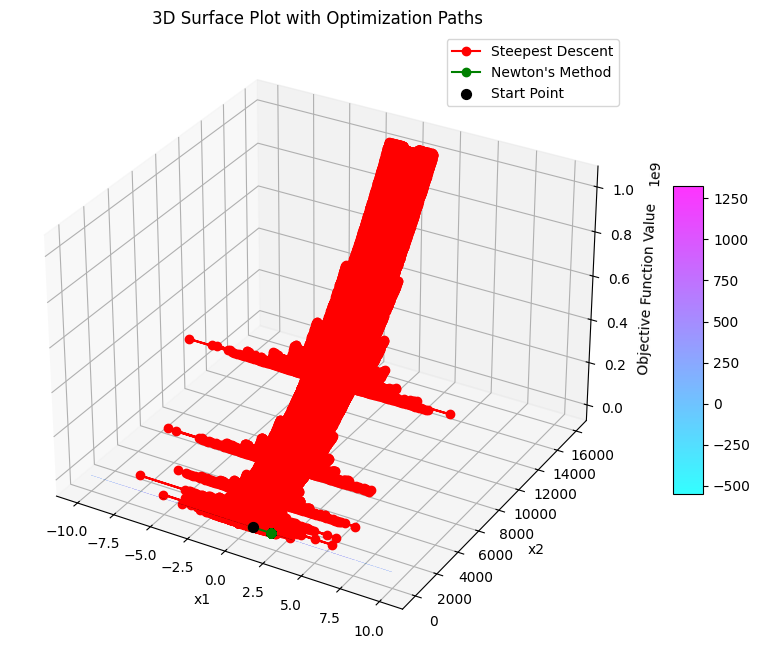

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D surface plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X1, X2, Z, cmap='cool', alpha=0.8)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Plot the optimization paths
ax.plot(sd_path[:, 0], sd_path[:, 1], [objective_function([x1, x2, 1.0]) for x1, x2 in sd_path], 'r-o', label='Steepest Descent')
ax.plot(nt_path[:, 0], nt_path[:, 1], [objective_function([x1, x2, 1.0]) for x1, x2 in nt_path], 'g-o', label="Newton's Method")

# Mark the starting point
ax.scatter(x0[0], x0[1], objective_function(x0), color='black', label='Start Point', s=50)

# Set labels and title
ax.set_title('3D Surface Plot with Optimization Paths')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('Objective Function Value')

# Add legend
ax.legend()

# Show the plot
plt.show()